# Gridding a synthetic ground survey

Let's perform a synthetic ground survey of the synthetic model made out of prisms and try to interpolate the observed data on a regular grid.
Because the model is synthetic, we can compute the true value of the field on this regular grid. Therefore, we have an objective way to score the interpolation. This allow us to objectively compare the different source layouts.

Firstly, we want to import useful packages and define some minor functions that will help us to visualize better the notebook cells and reduce ammount of code on them.

**Import useful packages**

In [1]:
from IPython.display import display, HTML
import itertools
import numpy as np
import pandas as pd
import verde as vd
import harmonica as hm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from eql_source_layouts import (
    ground_survey,
    synthetic_model,
    variable_relative_depth,
    block_reduce_points,
)

**Define functions to plot gridding results**

In [2]:
def plot_prediction(
    grid,
    prediction,
    target,
    title="Prediction",
    figsize=(12, 6),
    shrink_cbar=0.7,
):
    """
    Plot prediction and comparison with target
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=figsize)
    tmp = ax1.pcolormesh(*grid[:2], prediction)
    plt.colorbar(tmp, ax=ax1, shrink=shrink_cbar, label=field_units)
    ax1.set_aspect("equal")
    ax1.set_title(title)

    maxabs = vd.maxabs(target - prediction)
    tmp = ax2.pcolormesh(
        *grid[:2],
        target - best_prediction,
        vmin=-maxabs,
        vmax=maxabs,
        cmap="seismic",
    )
    plt.colorbar(tmp, ax=ax2, shrink=shrink_cbar, label=field_units)
    ax2.set_aspect("equal")
    ax2.set_title("Difference between target and prediction")
    plt.tight_layout()
    plt.show()
    
    
def histogram_errors(prediction, target, bins=20):
    """
    Plot histogram of prediction errors
    """
    plt.hist((target - prediction).ravel(), bins=bins)
    plt.title("Histogram of prediction errors")
    plt.show()

**Define function to print prediction parameters and scores with style**

In [3]:
def print_params_scores(parameters_sets, scores):
    """
    Display parameters and scores with style
    
    It also highlights the row that contains the maximum score
    """
    df = {}
    for keys in parameters_sets[0]:
        df[keys] = []
    df["score"] = []
    for parameters, score in zip(parameters_sets, scores):
        for key, param in parameters.items():
            df[key].append(param)
        df["score"].append(score)
    df = pd.DataFrame(df)
    display(df.style.apply(highlight_max_row, column="score", axis=None))


def highlight_max_row(df, column, color="orange"):
    """
    Highlight the row that contains the max value of a column
    """
    style = df.copy()
    is_max = (df[column] == df[column].max())
    background = [
        'background-color: {}'.format(color) if i else '' for i in is_max
    ]
    for col in style:
        style[col] = background
    return style

## Define parameters used on the gridding

Let's define all the parameters that will be used on this notebook in the following cells. These control the results that will be obtain on the rest of the notebook. If you want to change something (like the computation height of the grid, the survey region, interpolation parameters, etc), you can just do it here.

We will avoid hardcoding parameters outside of these few cells in order to facilitate reproducibility and keep things more organized.

In [4]:
# Define a survey region of 100km x 100km
region = (-50e3, 50e3, -50e3, 50e3)

# And the region for building the synthetic model
model_region = tuple(list(region) + [-10e3, 0])

# Define which field will be meassured
field = "g_z"
field_units = "mGal"

# Define the spacing of the target regular grid
# and its observation height
grid_spacing = 1e3
grid_elevation = 1500

# Define set of interpolation parameters
dampings = [None, 1e-4, 1e-3, 1e-2, 1e-1]
relative_depths = [1e3, 5e3, 10e3]
block_spacings = [0.25e3, 0.5e3, 1e3, 2e3, 3e3]
source_grid_spacings = [2.2e3, 3e3, 4e3]

## Create the synthetic ground survey

To create the ground survey we need to load the synthetic model made out of prisms, the location of the observation points and then compute the field that the prisms generate on those points.

Get coordinates of observation points

In [5]:
survey = ground_survey(region)
display(survey)

,easting,northing,elevation
6742,-49681.569291,-49617.959308,1296.61
6744,-48306.038677,-48429.399302,1322.21
6746,-47638.659940,-38055.253901,1285.02
6749,-46679.865824,-39577.160035,1287.77
6750,-46596.318411,-46733.283628,1383.17
...,...,...,...
11827,47040.070240,44769.983873,1164.93
11830,47748.722400,44646.816287,1239.61
11832,48040.888204,42428.942904,1383.47
11835,48791.314071,44112.950123,1380.73


Get the synthetic model

In [6]:
model = synthetic_model(model_region)
print(model.keys())
print("Number of prisms: {}".format(len(model["densities"])))

dict_keys(['prisms', 'densities'])
Number of prisms: 308


Compute the gravity field (g_z) on the observation points in mGal

In [7]:
coordinates = (survey.easting, survey.northing, survey.elevation)
survey[field] = hm.prism_gravity(
    coordinates, model["prisms"], model["densities"], field=field
)
display(survey)

,easting,northing,elevation,g_z
6742,-49681.569291,-49617.959308,1296.61,1.034678
6744,-48306.038677,-48429.399302,1322.21,1.194149
6746,-47638.659940,-38055.253901,1285.02,2.167710
6749,-46679.865824,-39577.160035,1287.77,2.195893
6750,-46596.318411,-46733.283628,1383.17,1.467855
...,...,...,...,...
11827,47040.070240,44769.983873,1164.93,1.648955
11830,47748.722400,44646.816287,1239.61,1.591410
11832,48040.888204,42428.942904,1383.47,1.777339
11835,48791.314071,44112.950123,1380.73,1.542187


Plot the observed field

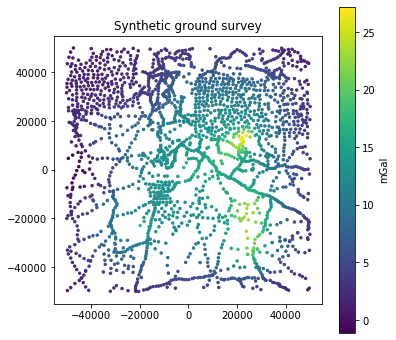

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.scatter(survey.easting, survey.northing, c=getattr(survey, field), s=6)
plt.colorbar(tmp, ax=ax, label=field_units)
ax.set_aspect("equal")
ax.set_title("Synthetic ground survey")
plt.show()

## Compute the field of the synthetic model on a grid

Now, let's compute the gravity field that the synthetic model generates on the regular grid. These results will serve as a target for the interpolations using different source layouts.

Build the regular grid

In [9]:
grid = vd.grid_coordinates(
    region=region, spacing=grid_spacing, extra_coords=grid_elevation
)

Compute the synthetic gravity field on the grid

In [10]:
target = hm.prism_gravity(
    grid, model["prisms"], model["densities"], field=field
)

Plot target gravity field

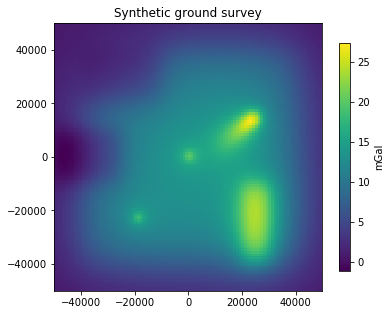

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
tmp = ax.pcolormesh(*grid[:2], target)
plt.colorbar(tmp, ax=ax, shrink=0.7, label=field_units)
ax.set_aspect("equal")
ax.set_title("Synthetic ground survey")
plt.show()

## Grid data with different source layouts and constant relative depth

Now, let's grid the synthetic data through different source layouts, but keeping the constant relative depth approach.
We will compare each interpolation with the target data in order to assess for the quality of each source layout.

Because the gridder could take several parameters that control the interpolation, we will perform several predictions with different set of parameters and then score each one of them against the target data. We will choose the best prediction as the one that produces the highest score. Because this score is computed agains *true data*, it's an objective quality estimator of the prediction.

### One source beneath each data point

Let's perform several interpolations on the grid by setting a single source point beneath each data point at a constant relative depth. This can be achieved throught `harmonica.EQLHarmonic` without any more work.
Each interpolation is performed with different values of the `damping` and `relative_depth` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [12]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1])
    for combo in itertools.product(dampings, relative_depths)
]

Perform the interpolations and score them against the target data

In [13]:
scores = []
for parameters in parameters_sets:
    # Initialize the gridder with one set of parameters
    eql = hm.EQLHarmonic(**parameters)
    
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [14]:
print_params_scores(parameters_sets, scores)

,damping,relative_depth,score
0,nan,1000,0.953919
1,nan,5000,0.993847
2,nan,10000,0.992027
3,0.0001,1000,0.953919
4,0.0001,5000,0.99786
5,0.0001,10000,0.997197
6,0.001,1000,0.953918
7,0.001,5000,0.99765
8,0.001,10000,0.997237
9,0.01,1000,0.953915


Keep the best prediction and plot it

Best score: 0.997860225576211
Best parameters: {'damping': 0.0001, 'relative_depth': 5000.0}


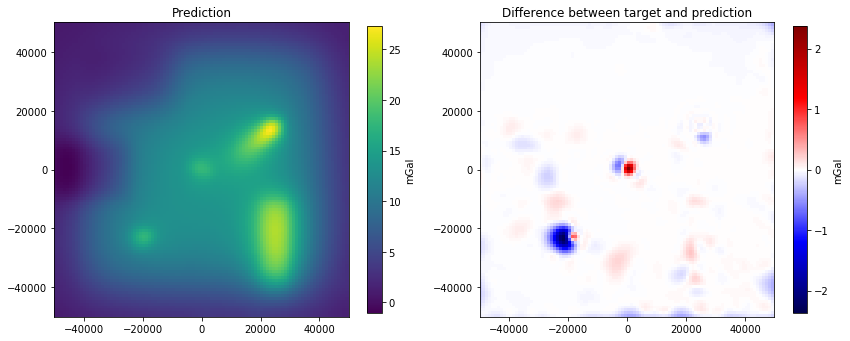

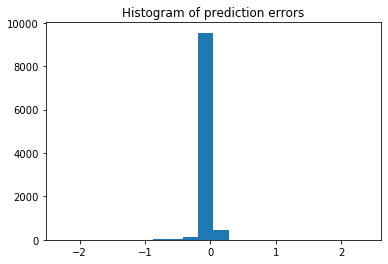

In [15]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameters_sets[best])

eql = hm.EQLHarmonic(**parameters_sets[best])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### Source beneath block reduced observation points

Now we will do the same, but with a different source layout: block reduce the observation points and put one source beneath each reduced coordinate at a constant relative depth.
For that we will need to make use of our `block_reduce_points()` function.
Each interpolation will be performed with different values of the `damping`, `relative_depth` and `spacing` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [16]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1], spacing=combo[2])
    for combo in itertools.product(dampings, relative_depths, block_spacings)
]

Perform the interpolations and score them against the target data

In [17]:
scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by block reducing the
    # observed coordinates and setting the point sources at a constant
    # relative depth beneath them.
    points = block_reduce_points(coordinates, spacing=parameters["spacing"])
    points = (points[0], points[1], points[2] - parameters["relative_depth"])

    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlighted row indicates the set of parameters that produces the maximum score.

In [18]:
print_params_scores(parameters_sets, scores)

,damping,relative_depth,spacing,score
0,nan,1000,250,0.953919
1,nan,1000,500,0.953917
2,nan,1000,1000,0.953749
3,nan,1000,2000,0.952181
4,nan,1000,3000,0.948425
5,nan,5000,250,0.998179
6,nan,5000,500,0.998311
7,nan,5000,1000,0.998194
8,nan,5000,2000,0.997718
9,nan,5000,3000,0.996782


Keep the best prediction and plot it

Best score: 0.9990499941042195
Best parameters: {'damping': None, 'relative_depth': 10000.0, 'spacing': 500.0}


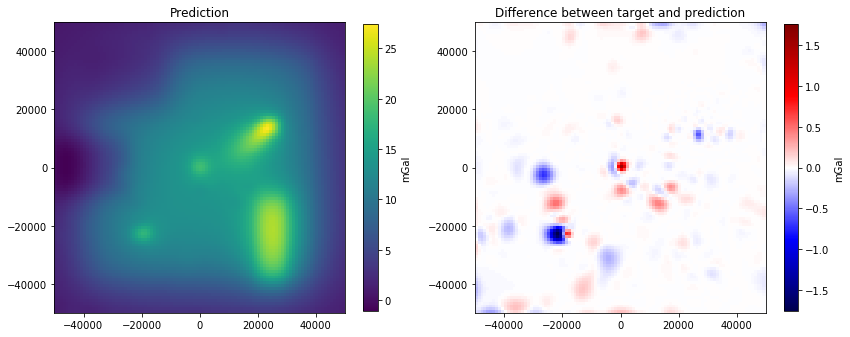

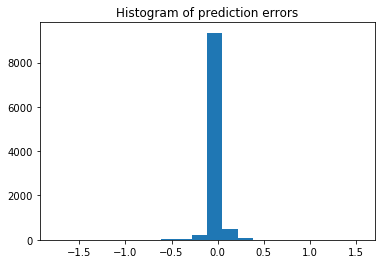

In [19]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = block_reduce_points(coordinates, spacing=best_params["spacing"])
points = (points[0], points[1], points[2] - best_params["relative_depth"])


eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### Source beneath center of block after reducing observation points

Now we will do the same, but with a different source layout: block reduce the observation points and put one source beneath each reduced coordinate at a constant relative depth.

This source layout is very similar to the latter one, but in this case the source points will be located under the center of the blocks instead of under the reduced coordinates.
We will also need to make use of our `block_reduce_points()` function, but now passing `center_coordinates` argument as True.
Each interpolation will be performed with different values of the `damping`, `relative_depth` and `spacing` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [20]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1], spacing=combo[2])
    for combo in itertools.product(dampings, relative_depths, block_spacings)
]

Perform the interpolations and score them against the target data

In [21]:
scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by block reducing the
    # observed coordinates and setting the point sources at a constant
    # relative depth beneath them.
    points = block_reduce_points(
        coordinates, spacing=parameters["spacing"], center_coordinates=True
    )
    points = (points[0], points[1], points[2] - parameters["relative_depth"])
    
    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlight row indicates the set of parameters that produces the maximum score.

In [22]:
print_params_scores(parameters_sets, scores)

,damping,relative_depth,spacing,score
0,nan,1000,250,0.954338
1,nan,1000,500,0.955393
2,nan,1000,1000,0.95969
3,nan,1000,2000,0.965749
4,nan,1000,3000,0.962072
5,nan,5000,250,0.996574
6,nan,5000,500,0.994909
7,nan,5000,1000,0.998267
8,nan,5000,2000,0.996848
9,nan,5000,3000,0.995657


Keep the best prediction and plot it

Best score: 0.9984038209941042
Best parameters: {'damping': None, 'relative_depth': 10000.0, 'spacing': 2000.0}


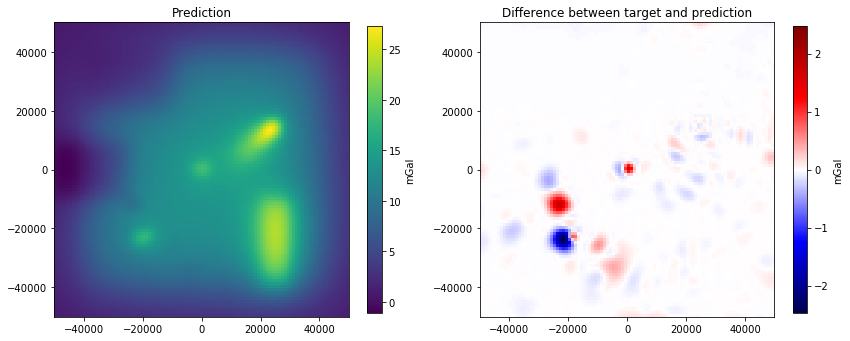

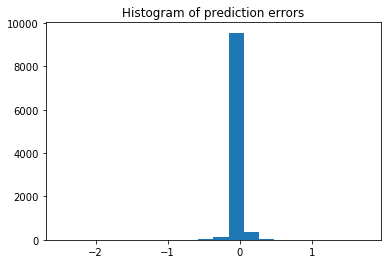

In [23]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

points = block_reduce_points(
    coordinates, spacing=best_params["spacing"], center_coordinates=True
)
points = (points[0], points[1], points[2] - best_params["relative_depth"])

eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)

### Regular grid of source points

Finally, let's build a regular grid of source points located at a relative constant depth beneath the mean elevation of observation points.
Each interpolation will be performed with different values of the `damping`, `relative_depth` and `spacing` parameters. Then we score the prediction against the target field and store all these scores.

Define the set of parameters that will be used on the interpolations

In [24]:
parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1], spacing=combo[2])
    for combo in itertools.product(dampings, relative_depths, source_grid_spacings)
]

Perform the interpolations and score them against the target data

In [25]:
# Compute mean elevation of observation points
mean_elevation = survey.elevation.mean()

scores = []
for parameters in parameters_sets:
    # Create the custom source points layout by block reducing the
    # observed coordinates and setting the point sources at a constant
    # relative depth beneath them.
    (easting, northing), _ = vd.block_split(
        coordinates, spacing=parameters["spacing"]
    )
    upward = np.full_like(easting, mean_elevation) - parameters["relative_depth"]
    points = (easting, northing, upward)
    
    if easting.size > 5000:
        print("too_big")
        break
    
    # Initialize the gridder passing the points layout and the damping
    eql = hm.EQLHarmonic(points=points, damping=parameters["damping"])
    
    # Fit the gridder giving the survey data
    eql.fit(coordinates, getattr(survey, field))
    
    # Predict the field on the regular grid
    prediction = eql.predict(grid)
    
    # Score the prediction against target data
    scores.append(r2_score(target, prediction))

Let's see all the computed scores. The highlight row indicates the set of parameters that produces the maximum score.

In [26]:
print_params_scores(parameters_sets, scores)

,damping,relative_depth,spacing,score
0,nan,1000,2200,-6.94202e+20
1,nan,1000,3000,-4734.21
2,nan,1000,4000,0.77065
3,nan,5000,2200,-7.57399e+15
4,nan,5000,3000,-11.8209
5,nan,5000,4000,0.99264
6,nan,10000,2200,-3.11306e+12
7,nan,10000,3000,0.858225
8,nan,10000,4000,0.994671
9,0.0001,1000,2200,-55.7598


Keep the best prediction and plot it

Best score: 0.9981309911904015
Best parameters: {'damping': 0.001, 'relative_depth': 5000.0, 'spacing': 2200.0}


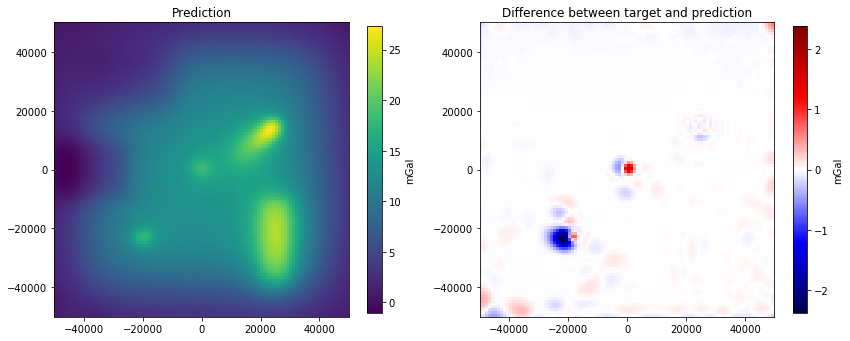

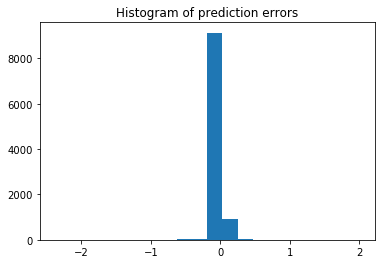

In [27]:
best = np.argmax(scores)
best_params = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_params)

(easting, northing), _ = vd.block_split(
    coordinates, spacing=best_params["spacing"]
)
upward = np.full_like(easting, mean_elevation) - best_params["relative_depth"]
points = (easting, northing, upward)

eql = hm.EQLHarmonic(points=points, damping=best_params["damping"])
eql.fit(coordinates, getattr(survey, field))
best_prediction = eql.predict(grid)

plot_prediction(grid, best_prediction, target)
histogram_errors(best_prediction, target)